# Board of Supervisors - Campaign Donations

In [2]:
import pandas as pd
import psycopg2 as pg
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
import sqlalchemy
import pandas.io.sql as psql
import numpy as np
import geopandas 
import descartes
import geojson
import scheme
import mapclassify
import json
import pysal as ps
import jenkspy
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')
import geopandas as gpd
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')


/Users/mhustiles/.virtualenvs/donations/lib/python3.6/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/Users/mhustiles/.virtualenvs/donations/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


ThemeRegistry.enable('latimes')

In [3]:
database_con = pg.connect("dbname=campaigns user=postgres")

In [4]:
alldonations =  psql.read_sql("SELECT * FROM contributions", database_con)

In [5]:
alldonations.head(1)

,Last Name,First Name,Committee ID,Committee Name,Office Type,District Number,Schedule,Type,Date,Amount Rcvd,...,Employer,Int Name,Int City,Int State,Int Zip Code,Int Occupation,Int Employer,Doc ID,Rec ID,x
0,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,I,2018-12-31,-1500.0,...,Miller Barondess LLP,,,,,,,,2557,164955


In [6]:
alldonations.columns = alldonations.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [7]:
alldonations['date'] = pd.to_datetime(alldonations['date'], errors='coerce')

In [11]:
alldonations['year'], alldonations['month'] = alldonations['date'].dt.year, alldonations['date'].dt.month
alldonations['year'] = alldonations['year'].astype(str)
alldonations['month'] = alldonations['month'].astype(str)
alldonations['amount_rcvd'] = alldonations['amount_rcvd'].astype(int)
alldonations['monthyear'] = alldonations['month'] + '/' + alldonations['year']

In [12]:
alldonations[['date', 'amount_rcvd']].groupby(alldonations.date.dt.to_period("M")).agg(['sum', 'size'])

amount_rcvd      
                sum  size
date                     
2005-05         100     1
2007-01       35350    40
2007-02       52750    61
2007-03      165050   225
2007-04      296593   410
...             ...   ...
2019-02      610890   699
2019-03      479805   509
2019-04      420283   564
2019-05      545495   706
2019-06     1003559  1398

[151 rows x 2 columns]

## Group data by supervisor, month, year, zip

### Filter out donations in cases where candidate is running in 2020

In [499]:
thiscycle = alldonations[(alldonations['nu_date'] > '2018-06-30') & (alldonations['committee_name'].str.contains('2020', case = False)
)] 

In [500]:
thiscycle.groupby('committee_name').size()

committee_name
Committee to Re-Elect Jackie Lacey for District Attorney 2020    444
Holly J. Mitchell for County Supervisor 2020                     767
JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2                         894
Janice Hahn for Supervisor 2020                                  276
Jeong for County Supervisor 2020                                  82
Joseph F. Iniguez for District Attorney 2020                     181
Kathryn Barger for Supervisor 2020                               935
Wesson for Supervisor 2020                                       961
dtype: int64

In [709]:
thiscycle.head(3)

,last_name,first_name,committee_id,committee_name,office_type,district_number,schedule,type,date,amount_rcvd,...,int_zip_code,int_occupation,int_employer,doc_id,rec_id,x,nu_date,year,month,monthyear
0,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,I,2018-12-31,-1500,...,,,,,2557,164955,2018-12-31,2018,12,12/2018
1,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,I,2018-12-31,-250,...,,,,,2557,164953,2018-12-31,2018,12,12/2018
2,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,I,2018-12-31,100,...,,,,,2557,164852,2018-12-31,2018,12,12/2018


In [729]:
thiscycletotals = thiscycle.groupby(['first_name','last_name'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

thiscyclemath = thiscycle[['nu_date', 'amount_rcvd']].groupby(thiscycle.nu_date.dt.to_period("M")).agg(['sum', 'size', 'mean'], as_index=False)

In [730]:
thiscycletotals
flat_columns = [''.join(t) for t in thiscycletotals.columns]
thiscycletotals.columns = flat_columns
thiscycletotals['amount_rcvdmean'] = thiscycletotals['amount_rcvdmean'].round(0)
thiscycletotals['last_name'] = thiscycletotals['last_name'].str.upper()

In [731]:
thiscyclemath
flat_columns = [''.join(t) for t in thiscyclemath.columns]
thiscyclemath.columns = flat_columns
thiscyclemath['amount_rcvdmean'] = thiscyclemath['amount_rcvdmean'].round(0)

## Let's make some charts

### Totals donations collected by 2020 supervisor candidates since last summer

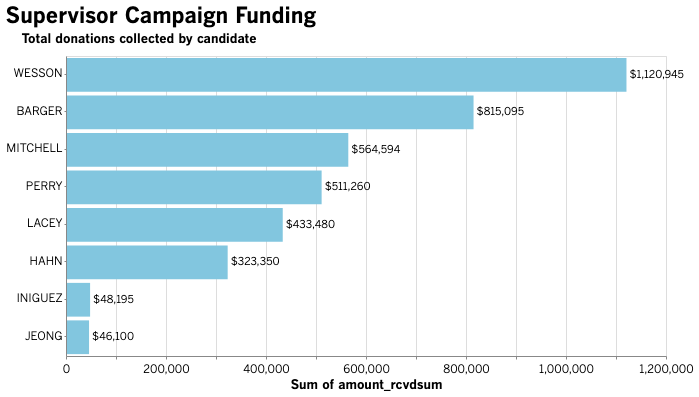

In [732]:
bars = alt.Chart(thiscycletotals, title="Supervisor Campaign Funding").mark_bar().encode(
    x='sum(amount_rcvdsum):Q',
    y=alt.Y(
        'last_name:N',
        title="Total donations collected by candidate",
        sort=alt.EncodingSortField(
            field="amount_rcvdsum",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
    )
)
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdsum:Q', format="$,")
)
    
(bars + text).properties(height=300, width=600)

### What's the average donation size? 

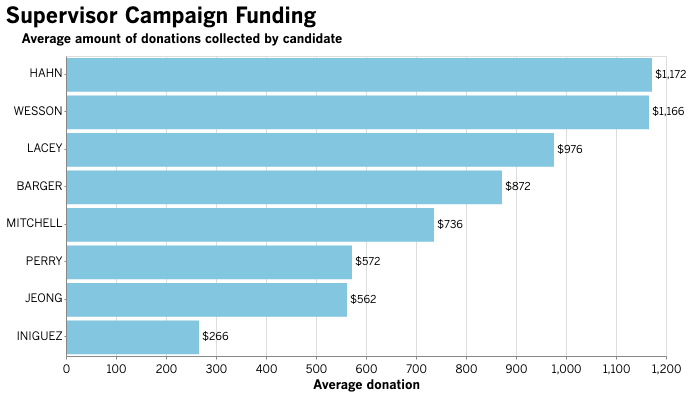

In [504]:
bars = alt.Chart(thiscycletotals, title="Supervisor Campaign Funding").mark_bar().encode(
    x=alt.X(
        'sum(amount_rcvdmean):Q',
        title="Average donation"),
    y=alt.Y(
        'last_name:N',
        title="Average amount of donations collected by candidate",
        sort=alt.EncodingSortField(
            field="amount_rcvdmean",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
    )
)
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdmean:Q', format="$,")
)
    
(bars + text).properties(height=300, width=600)

### How many donations have those candidates received? 

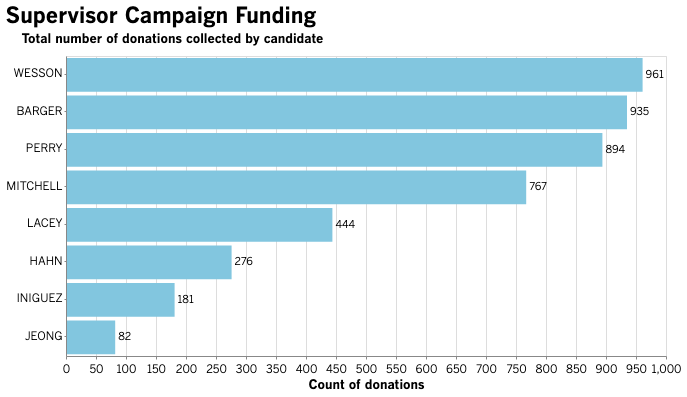

In [505]:
bars = alt.Chart(thiscycletotals, title="Supervisor Campaign Funding").mark_bar().encode(
    x=alt.X(
        'sum(amount_rcvdsize):Q',
        title="Count of donations"),
    y=alt.Y(
        'last_name:N',
        title="Total number of donations collected by candidate",
        sort=alt.EncodingSortField(
            field="amount_rcvdsize",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
    )
)
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdsize:Q', format=",")
)
    
(bars + text).properties(height=300, width=600)

In [506]:
thiscyclezips = thiscycle.groupby(['first_name','last_name', 'committee_name', 'contributor_zip_code'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

In [507]:
# thiscyclezips = thiscycle.groupby(['last_name', 'contributor_zip_code'], as_index=False).agg({'amount_rcvd': [np.sum, np.size, np.mean]}, as_index=False)

thiscyclezips = thiscycle.groupby(['first_name','last_name', 'committee_name', 'contributor_zip_code'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

In [508]:
thiscyclezips
flat_columns = [''.join(t) for t in thiscyclezips.columns]
thiscyclezips.columns = flat_columns
thiscyclezips['amount_rcvdmean'] = thiscyclezips['amount_rcvdmean'].astype(int)
thiscyclezips.head(10)

,first_name,last_name,committee_name,contributor_zip_code,amount_rcvdsize,amount_rcvdmean,amount_rcvdsum
0,Chan,Jeong,Jeong for County Supervisor 2020,12901,1,500,500
1,Chan,Jeong,Jeong for County Supervisor 2020,90004,3,400,1200
2,Chan,Jeong,Jeong for County Supervisor 2020,90005,4,1175,4700
3,Chan,Jeong,Jeong for County Supervisor 2020,90006,6,266,1600
4,Chan,Jeong,Jeong for County Supervisor 2020,90010,11,418,4600
5,Chan,Jeong,Jeong for County Supervisor 2020,90012,1,250,250
6,Chan,Jeong,Jeong for County Supervisor 2020,90015,2,500,1000
7,Chan,Jeong,Jeong for County Supervisor 2020,90017,3,1333,4000
8,Chan,Jeong,Jeong for County Supervisor 2020,90019,3,183,550
9,Chan,Jeong,Jeong for County Supervisor 2020,90020,9,733,6600


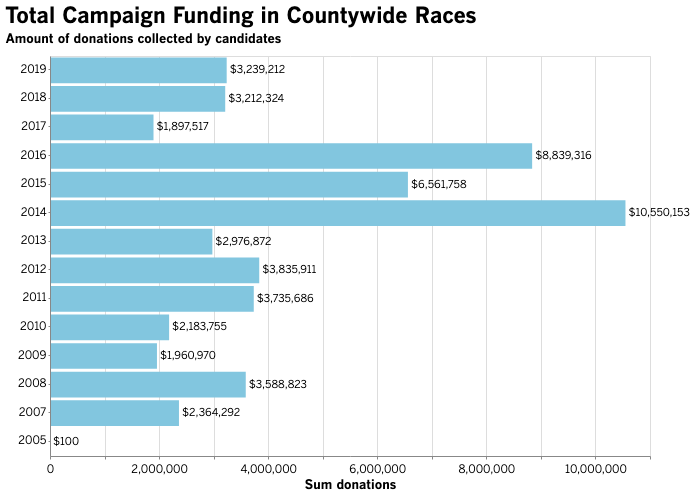

In [509]:
bars = alt.Chart(sumyear, title="Total Campaign Funding in Countywide Races").mark_bar().encode(
    x=alt.X(
        'amount_rcvd:Q',
        title="Sum donations"),
    y=alt.Y(
        'year:N',
        title="Amount of donations collected by candidates",
        sort=alt.EncodingSortField(
            field="year",  
            op="sum",  
            order="descending",  
    )
))

text = bars.mark_text(
    align='left',
    baseline='middle',
    font='Benton Gothic, sans',
    dx=3
).encode(
    text=alt.Text('amount_rcvd:Q', format='$,')
)

(bars + text).properties(height=400, width=600)

In [510]:
thiscycle[(thiscycle.last_name == 'Mitchell') & (thiscycle.month == '2')]

,last_name,first_name,committee_id,committee_name,office_type,district_number,schedule,type,date,amount_rcvd,...,int_zip_code,int_occupation,int_employer,doc_id,rec_id,x,nu_date,year,month,monthyear
73813,Mitchell,Holly J.,1415889,Holly J. Mitchell for County Supervisor 2020,CSU,C02,A,O,2019-02-28,1500,...,,,,,2578,165731,2019-02-28,2019,2,2/2019
73814,Mitchell,Holly J.,1415889,Holly J. Mitchell for County Supervisor 2020,CSU,C02,A,O,2019-02-28,1000,...,,,,,2578,165732,2019-02-28,2019,2,2/2019
73815,Mitchell,Holly J.,1415889,Holly J. Mitchell for County Supervisor 2020,CSU,C02,A,O,2019-02-28,500,...,,,,,2578,165733,2019-02-28,2019,2,2/2019
73816,Mitchell,Holly J.,1415889,Holly J. Mitchell for County Supervisor 2020,CSU,C02,A,O,2019-02-28,1000,...,,,,,2578,165734,2019-02-28,2019,2,2/2019
73820,Mitchell,Holly J.,1415889,Holly J. Mitchell for County Supervisor 2020,CSU,C02,A,O,2019-02-28,1500,...,,,,,2578,165738,2019-02-28,2019,2,2/2019
73821,Mitchell,Holly J.,1415889,Holly J. Mitchell for County Supervisor 2020,CSU,C02,A,O,2019-02-28,1500,...,,,,,2578,165739,2019-02-28,2019,2,2/2019
73822,Mitchell,Holly J.,1415889,Holly J. Mitchell for County Supervisor 2020,CSU,C02,A,O,2019-02-28,1500,...,,,,,2578,165740,2019-02-28,2019,2,2/2019
73823,Mitchell,Holly J.,1415889,Holly J. Mitchell for County Supervisor 2020,CSU,C02,A,O,2019-02-28,1250,...,,,,,2578,165741,2019-02-28,2019,2,2/2019
73826,Mitchell,Holly J.,1415889,Holly J. Mitchell for County Supervisor 2020,CSU,C02,A,I,2019-02-28,100,...,,,,,2578,165744,2019-02-28,2019,2,2/2019
73829,Mitchell,Holly J.,1415889,Holly J. Mitchell for County Supervisor 2020,CSU,C02,A,C,2019-02-28,1500,...,,,,,2578,165747,2019-02-28,2019,2,2/2019


***

In [667]:
thiscycletime = thiscycle.groupby(['monthyear','year','month', 'last_name'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

In [668]:
thiscycletime
flat_columns = [''.join(t) for t in thiscycletime.columns]
thiscycletime.columns = flat_columns
thiscycletime['amount_rcvdmean'] = thiscyclezips['amount_rcvdmean'].astype(int)
thiscycletime['amount_rcvdmean'] = thiscyclezips['amount_rcvdmean'].round()
thiscycletime.head(20)

,monthyear,year,month,last_name,amount_rcvdsize,amount_rcvdmean,amount_rcvdsum
0,1/2019,2019,1,Barger,11,500,11850
1,1/2019,2019,1,Hahn,1,400,1500
2,1/2019,2019,1,Lacey,13,1175,16500
3,1/2019,2019,1,PERRY,59,266,37930
4,1/2019,2019,1,Wesson,78,418,81800
5,11/2018,2018,11,Lacey,5,250,5500
6,12/2018,2018,12,Barger,213,500,244150
7,12/2018,2018,12,Hahn,6,1333,4200
8,12/2018,2018,12,Lacey,94,183,120000
9,12/2018,2018,12,Wesson,357,733,455299


### Count of all 2020 donations by day. Feb. 27 stands out. 

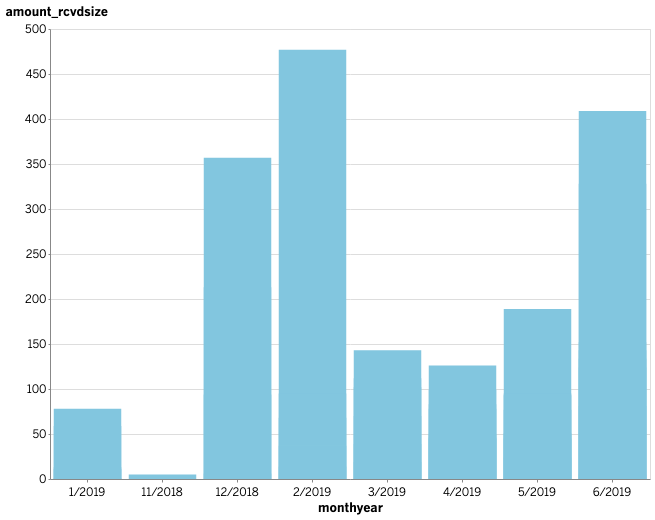

In [761]:
alt.Chart(thiscycletime).mark_bar().encode(
    x='monthyear:N',
    y="amount_rcvdsize:Q",
).properties(width=600)

### Individual dataframes for each candidate

In [514]:
bargerall = thiscycle[(thiscycle.last_name == 'Barger')]
hahnall = thiscycle[(thiscycle.last_name == 'Hahn')]
perryall = thiscycle[(thiscycle.last_name == 'PERRY')]
wessonall = thiscycle[(thiscycle.last_name == 'Wesson')]
iniguezall = thiscycle[(thiscycle.last_name == 'Iniguez')]
jeongall = thiscycle[(thiscycle.last_name == 'Jeong')]
mitchellall = thiscycle[(thiscycle.last_name == 'Mitchell')]

### What's up with Sen. Mitchell's fundraising in February? 

In [515]:
mitchellfeb = mitchellall[(mitchellall.month == 2)]
mitchellsacramento = thiscycle[(thiscycle.last_name == 'Mitchell') & (thiscycle.contributor_zip_code == '95814')]

In [516]:
mitchellall.groupby(['month']).size().to_frame('size').reset_index().sort_values(['month', 'size'], ascending=[True, False])

,month,size
0,2,477
1,3,19
2,4,83
3,5,45
4,6,143


### Donations from 95814

In [517]:
mitchellall[(mitchellall.month == 2) & (mitchellall.contributor_zip_code == '95814')][['contributor_zip_code', 'date', 'amount_rcvd']]

,contributor_zip_code,date,amount_rcvd


### Which zip codes were most common for Mitchell? 

In [518]:
mitchellallzips = mitchellall.groupby(['contributor_zip_code']).size().to_frame('size').reset_index().sort_values(['size', 'size'], ascending=[False, True])
mitchellallzips.head(15)

,contributor_zip_code,size
279,95814,71
94,90056,25
89,90043,23
63,90008,12
109,90232,12
97,90064,10
69,90017,9
71,90019,9
77,90025,9
90,90045,9


In [522]:
sumyear = alldonations.groupby(['year'], as_index=False).agg({"amount_rcvd": "sum"})
sumzips = alldonations.groupby(['contributor_zip_code'], as_index=False).agg({"amount_rcvd": "sum"})

In [559]:
sumzips.head(10)

,contributor_zip_code,amount_rcvd
0,,135121
1,0,21550
2,10001,9150
3,10003,12700
4,10004,2600
5,10005,1000
6,10006,2500
7,10007,1400
8,10010,4550
9,10011,23000


In [524]:
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

In [525]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [563]:
thiscycle.groupby('committee_name').describe()

amount_rcvd               \
                                                         count         mean   
committee_name                                                                
Committee to Re-Elect Jackie Lacey for District...       444.0   976.306306   
Holly J. Mitchell for County Supervisor 2020             767.0   736.106910   
JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2                 894.0   571.879195   
Janice Hahn for Supervisor 2020                          276.0  1171.557971   
Jeong for County Supervisor 2020                          82.0   562.195122   
Joseph F. Iniguez for District Attorney 2020             181.0   266.270718   
Kathryn Barger for Supervisor 2020                       935.0   871.759358   
Wesson for Supervisor 2020                               961.0  1166.436004   

                                                                        \
                                                           std     min   
committee_name                                                           
Committee to Re-Elect Jackie Lacey for District...  522.921323   100.0   
Holly J. Mitchell for County Supervisor 2020        570.623400 -1500.0   
JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2            527.984073    25.0   
Janice Hahn for Supervisor 2020                     442.345936   100.0   
Jeong for County Supervisor 2020                    509.390884   100.0   
Joseph F. Iniguez for District Attorney 2020        320.252572    10.0   
Kathryn Barger for Supervisor 2020                  835.901679 -1500.0   
Wesson for Supervisor 2020                          473.097246 -1500.0   

                                                                            \
                                                       25%     50%     75%   
committee_name                                                               
Committee to Re-Elect Jackie Lacey for District...   500.0  1000.0  1500.0   
Holly J. Mitchell for County Supervisor 2020         250.0   500.0  1500.0   
JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2             100.0   300.0  1000.0   
Janice Hahn for Supervisor 2020                     1000.0  1500.0  1500.0   
Jeong for County Supervisor 2020                     200.0   400.0  1000.0   
Joseph F. Iniguez for District Attorney 2020         100.0   150.0   250.0   
Kathryn Barger for Supervisor 2020                   500.0   750.0  1500.0   
Wesson for Supervisor 2020                          1000.0  1500.0  1500.0   

                                                            amount_pd       \
                                                        max     count mean   
committee_name                                                               
Committee to Re-Elect Jackie Lacey for District...   1500.0     444.0  0.0   
Holly J. Mitchell for County Supervisor 2020         1500.0     767.0  0.0   
JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2             1500.0     894.0  0.0   
Janice Hahn for Supervisor 2020                      1500.0     276.0  0.0   
Jeong for County Supervisor 2020                     1500.0      82.0  0.0   
Joseph F. Iniguez for District Attorney 2020         1500.0     181.0  0.0   
Kathryn Barger for Supervisor 2020                  20000.0     935.0  0.0   
Wesson for Supervisor 2020                           1500.0     961.0  0.0   

                                                                             \
                                                    std  min  25%  50%  75%   
committee_name                                                                
Committee to Re-Elect Jackie Lacey for District...  0.0  0.0  0.0  0.0  0.0   
Holly J. Mitchell for County Supervisor 2020        0.0  0.0  0.0  0.0  0.0   
JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2            0.0  0.0  0.0  0.0  0.0   
Janice Hahn for Supervisor 2020                     0.0  0.0  0.0  0.0  0.0   
Jeong for County Supervisor 2020                    0.0  0.0  0.0  0.0  0.0   
Joseph F. Inigue